# Sentiment analysis based on Women E-commerce store reviews
## Prepared by: Claudia Słaboń

### The project is divided into steps:
#### Introduction
#### Missing Values
####  Text Data Processing:
1. Converting words to lowercase
2. Stopwords removal
3. Tokenization
4. Padding
5. Embedding using GloVe and Word2Vec
<br><br> Machine Learning Methods:
<br> 1) benchmark model: Multinomial Naive Bayes
<br> 2) student model: LSTM model using GloVe and Word2Vec approach
<br> Conclusions

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow
from tensorflow import keras
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [72]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Introduction

In [2]:
df_source = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [3]:
df_source.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df_source.rename(columns = {'Unnamed: 0':'ID', 'Review Text':'Review_Text'}, inplace = True)
df_source.set_index('ID', inplace = True)
df_source.head()

,Clothing ID,Age,Title,Review_Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
ID,,,,,,,,,,
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


<AxesSubplot:xlabel='Age', ylabel='count'>

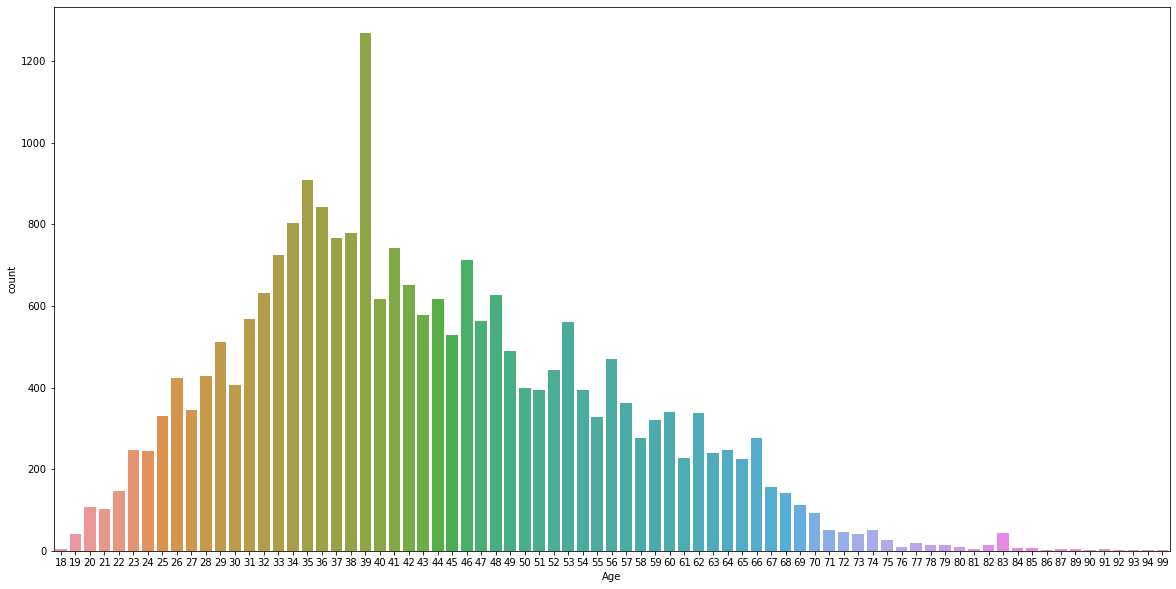

In [5]:
plt.figure(figsize=(20,10))
sns.countplot(x=df_source["Age"])

<AxesSubplot:xlabel='Rating', ylabel='count'>

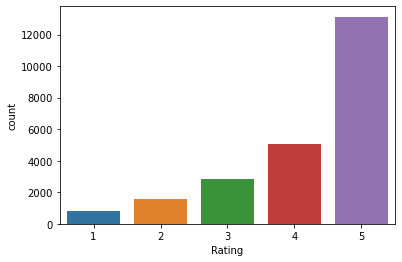

In [6]:
sns.countplot(x=df_source["Rating"])

# Null variables

In [76]:
print(df_source.isnull().sum())

Clothing ID                   0
Age                           0
Title                      3810
Review_Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [7]:
df = df_source[['Rating', 'Review_Text']]
df = pd.DataFrame(df)
df.head()

,Rating,Review_Text
ID,,
0,4,Absolutely wonderful - silky and sexy and comf...
1,5,Love this dress! it's sooo pretty. i happene...
2,3,I had such high hopes for this dress and reall...
3,5,"I love, love, love this jumpsuit. it's fun, fl..."
4,5,This shirt is very flattering to all due to th...


Removing empty rows

In [8]:
df.dropna(subset=['Review_Text'], inplace=True)
print(df.isnull().sum())
df["Rating"].size

Rating         0
Review_Text    0
dtype: int64


22641

# Changing ratings:
<br> 1 or 2 as negative review
<br> 3 as neutral
<br> 4 and 5 as positive

In [9]:
df.Rating = df.Rating.astype(str)
df.dtypes

Rating         object
Review_Text    object
dtype: object

In [10]:
df.Rating[df.Rating == '1'] = 'negative'
df.Rating[df.Rating == '2'] = 'negative'
df.Rating[df.Rating == '3'] = 'neutral'
df.Rating[df.Rating == '4'] = 'positive'
df.Rating[df.Rating == '5'] = 'positive'

In [11]:
df.head()

,Rating,Review_Text
ID,,
0,positive,Absolutely wonderful - silky and sexy and comf...
1,positive,Love this dress! it's sooo pretty. i happene...
2,neutral,I had such high hopes for this dress and reall...
3,positive,"I love, love, love this jumpsuit. it's fun, fl..."
4,positive,This shirt is very flattering to all due to th...


Text Data Processing:
<br> 1. Converting words to lowercase
<br> 2. Stopwords removal
<br> 3. Tokenization
<br> 4. Padding
<br> 5. Embedding using GloVe and Word2Vec

# Removing numbers, symbols and converting words to lowercase.

In [12]:
def tidy_text(text):
    text = re.sub(r'[^A-Za-z]+', ' ', text)
    text = re.sub(r"it s", 'it is', text)
    text = re.sub(r"i m", 'i am', text)
    return text

In [13]:
df.Review_Text = df.Review_Text.str.lower()
df.Review_Text = df.Review_Text.apply(lambda x: tidy_text(str(x)))

In [14]:
pd.Series(' '.join(df['Review_Text']).split()).value_counts().head(10)

the     76168
i       67070
it      49285
and     49010
a       43120
is      37066
this    25762
to      24583
in      20753
but     16556
dtype: int64

# Removing stopwords

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
rm_stop_words = lambda x: [[w for w in word_tokenize(text) if w not in stop_words] for text in sent_tokenize(x)]
df['Review_Text'] = df['Review_Text'].apply(rm_stop_words)
df_m = df.copy()

In [17]:
df['Review_Text']

ID
0        [[absolutely, wonderful, silky, sexy, comforta...
1        [[love, dress, sooo, pretty, happened, find, s...
2        [[high, hopes, dress, really, wanted, work, in...
3        [[love, love, love, jumpsuit, fun, flirty, fab...
4        [[shirt, flattering, due, adjustable, front, t...
                               ...                        
23481    [[happy, snag, dress, great, price, easy, slip...
23482    [[reminds, maternity, clothes, soft, stretchy,...
23483    [[fit, well, top, see, never, would, worked, g...
23484    [[bought, dress, wedding, summer, cute, unfort...
23485    [[dress, lovely, platinum, feminine, fits, per...
Name: Review_Text, Length: 22641, dtype: object

Combining tokens into sentences and removing all rows with 0 words after stopwords removal.

In [18]:
def combine_text(text):
    try:
        return ' '.join(text[0])
    except:
        return np.nan
df.Review_Text = df.Review_Text.apply(lambda x: combine_text(x))

In [19]:
df.head

<bound method NDFrame.head of          Rating                                        Review_Text
ID                                                                
0      positive        absolutely wonderful silky sexy comfortable
1      positive  love dress sooo pretty happened find store gla...
2       neutral  high hopes dress really wanted work initially ...
3      positive  love love love jumpsuit fun flirty fabulous ev...
4      positive  shirt flattering due adjustable front tie perf...
...         ...                                                ...
23481  positive  happy snag dress great price easy slip flatter...
23482   neutral  reminds maternity clothes soft stretchy shiny ...
23483   neutral  fit well top see never would worked glad able ...
23484   neutral  bought dress wedding summer cute unfortunately...
23485  positive  dress lovely platinum feminine fits perfectly ...

[22641 rows x 2 columns]>

In [20]:
df_benchmark = df.copy()

Word Cloud on the whole dataset

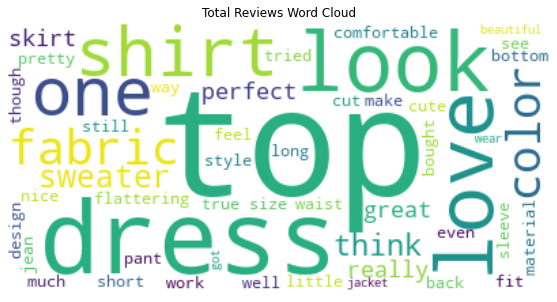

In [21]:
t = " ".join(review for review in df.Review_Text)
img = WordCloud(background_color="white", max_words=50).generate(t)
plt.figure(figsize=(10,5))
plt.imshow(img, interpolation='bilinear')
plt.axis("off")
plt.title('Total Reviews Word Cloud')
plt.show()

In [22]:
negative = df[df["Rating"] == 'negative']
neutral = df[df["Rating"] == 'neutral']
positive = df[df["Rating"] == 'positive']
print(len(negative))
print(len(neutral))
print(len(positive))

2370
2823
17448


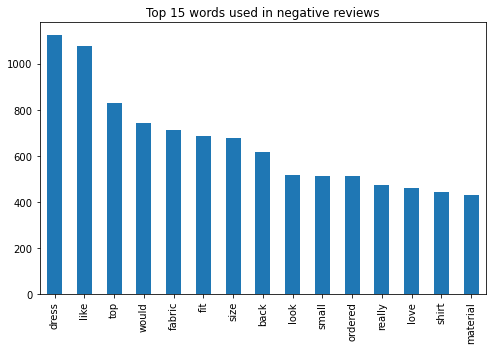

In [23]:
n = pd.Series(' '.join(negative['Review_Text']).split())
plt.figure(figsize=(8,5))
n.value_counts()[:15].plot.bar() 
plt.title("Top 15 words used in negative reviews")
plt.show()

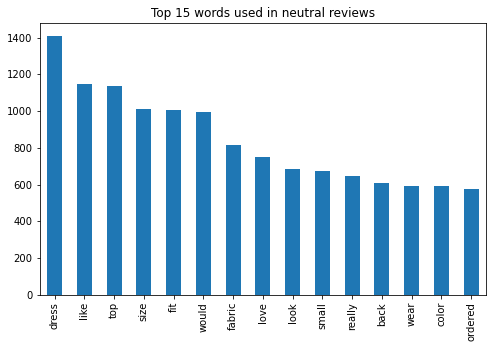

In [24]:
neu = pd.Series(' '.join(neutral['Review_Text']).split())
plt.figure(figsize=(8,5))
neu.value_counts()[:15].plot.bar() 
plt.title("Top 15 words used in neutral reviews")
plt.show()

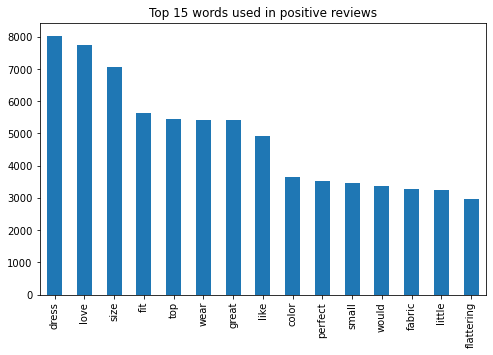

In [25]:
p = pd.Series(' '.join(positive['Review_Text']).split())
plt.figure(figsize=(8,5))
p.value_counts()[:15].plot.bar() 
plt.title("Top 15 words used in positive reviews")
plt.show()

# Multinominal Naive Bayes

In [97]:
df_benchmark.head()

,Rating,Review_Text
ID,,
0,positive,absolutely wonderful silky sexy comfortable
1,positive,love dress sooo pretty happened find store gla...
2,neutral,high hopes dress really wanted work initially ...
3,positive,love love love jumpsuit fun flirty fabulous ev...
4,positive,shirt flattering due adjustable front tie perf...


In [195]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(df_benchmark, df_benchmark.Rating, test_size=0.25, random_state=0)
print(X_train_b.shape, Y_train_b.shape, X_test_b.shape, Y_test_b.shape)

(16980, 2) (16980,) (5661, 2) (5661,)


In [196]:
vectorizer = CountVectorizer()
X_train_b = vectorizer.fit_transform(X_train_b["Review_Text"])
X_test_b = vectorizer.transform(X_test_b["Review_Text"])

In [197]:
mnb = MultinomialNB()
mnb.fit(X_train_b,Y_train_b)
mnb_pred = mnb.predict(X_test_b)

In [198]:
from sklearn.metrics import accuracy_score
ac = accuracy_score(Y_test_b, mnb_pred)
print("Accuracy of the model is equal to:",ac.round(3))

Accuracy of the model is equal to: 0.806


[106 244 407]


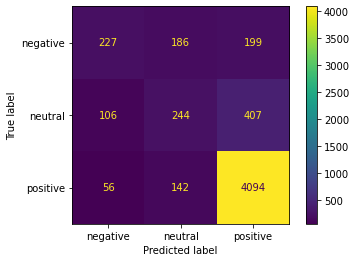

In [213]:
cm = confusion_matrix(Y_test_b, mnb_pred)
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix
print(cm)
plot_confusion_matrix(mnb, X_test_b, Y_test_b, values_format = '') 
#cm_display = ConfusionMatrixDisplay(cm).plot(cmap='viridis')

# Tokenization

In [103]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(list(df['Review_Text']))
seq = tokenizer.texts_to_sequences(df['Review_Text']) #takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary
word_index=tokenizer.word_index #the most frequent word = index 1

In [104]:
longest = 0
for s in seq:
    longer=len(s)
    if longer>longest:
        longest=longer
print("The longest cleaned review consists of",longest,"words.")

shortest = 20
for s in seq:
    shorter=len(s)
    if shorter<shortest:
        shortest=shorter
print("The shortest cleaned review consists of",shortest,"words.")

word_numbers = []
for s in seq:
    l=len(s)
    word_numbers.append(l)
avg_word = round(sum(word_numbers)/len(word_numbers))
print("The average number of words used in clean review equals",avg_word)

The longest cleaned review consists of 58 words.
The shortest cleaned review consists of 2 words.
The average number of words used in clean review equals 28


# Padding
<br> creating matrix n x 50

In [105]:
df_model = pad_sequences(seq, maxlen=50)

# Creating an embedding matrix

In [107]:
embeddings_dict = {}
def emb_matrix(emb_file, word_index, num_words, embedding_dim):
    with open(emb_file, encoding = 'utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
#        file.close()
    
        embedding_matrix = np.zeros((num_words, embedding_dim))
        for word, pos in word_index.items():
            if pos >=num_words:
                continue
            embedding_vector = embeddings_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[pos] = embedding_vector
        return embedding_matrix

GloVe

In [108]:
emb_matrixx = emb_matrix("gdrive/My Drive/glove.6B.50d.txt", word_index, len(word_index), 50)

In [109]:
df_m['Review_Text'] = df_m['Review_Text'].apply(lambda x: x[0])

In [110]:
df_m['Review_Text']

ID
0        [absolutely, wonderful, silky, sexy, comfortable]
1        [love, dress, sooo, pretty, happened, find, st...
2        [high, hopes, dress, really, wanted, work, ini...
3        [love, love, love, jumpsuit, fun, flirty, fabu...
4        [shirt, flattering, due, adjustable, front, ti...
                               ...                        
23481    [happy, snag, dress, great, price, easy, slip,...
23482    [reminds, maternity, clothes, soft, stretchy, ...
23483    [fit, well, top, see, never, would, worked, gl...
23484    [bought, dress, wedding, summer, cute, unfortu...
23485    [dress, lovely, platinum, feminine, fits, perf...
Name: Review_Text, Length: 22641, dtype: object

Word2Vec

In [111]:
from gensim.models import Word2Vec

In [112]:
model_word = Word2Vec(df_m['Review_Text'],
                     iter=10,
                     size=50,
                     window=5,
                     min_count=5,
                     workers=10,
                     sg=0)

In [113]:
model_word.wv.most_similar('bad')

[('disappointing', 0.7198618650436401),
 ('awful', 0.7071894407272339),
 ('iseemed', 0.681943953037262),
 ('terrible', 0.6738508343696594),
 ('sadly', 0.6671820282936096),
 ('unflattering', 0.6316266059875488),
 ('strange', 0.6170933842658997),
 ('blah', 0.6166658401489258),
 ('poor', 0.6064687967300415),
 ('okay', 0.6013490557670593)]

In [114]:
model_word.wv.save_word2vec_format('word2.txt', binary=False)

In [115]:
emb_matrixx2 = emb_matrix("word2.txt", word_index, len(word_index), 50)

In [116]:
print("There is",len(word_index),"words. \nThis number will be an input for embedding layer")

There is 13729 words. 
This number will be an input for embedding layer


In [117]:
emb_matrixx[[1]]

array([[-0.77318001,  0.34386   , -1.94140005, -0.77677   ,  0.79316002,
         0.20095   , -0.15133999, -0.81111997, -0.62295997, -0.86132002,
         0.084821  , -0.2078    ,  0.29567   ,  0.32460001,  0.27000999,
         0.43369001, -0.98171002, -0.43156999,  0.54171997, -1.53460002,
        -0.030456  ,  0.58648002, -0.095475  ,  0.045125  , -0.8933    ,
        -1.06340003, -1.50989997,  1.03079998,  0.39989999, -1.11839998,
         1.84949994,  0.91908997, -0.51056999,  0.34020999,  0.23894   ,
         0.47147   ,  0.077344  ,  0.46934   , -1.12989998, -0.32453999,
         0.20254   ,  0.48451   ,  0.46428001, -0.090925  ,  0.44786999,
        -0.98458999,  0.45304   , -1.26730001, -0.30428001,  0.26306   ]])

In [118]:
len(emb_matrixx)

13729

In [119]:
emb_matrixx2[[1]]

array([[ 0.03615383, -0.06034041,  1.90543628,  0.80344868, -1.49994504,
        -1.47552383, -0.9893412 ,  0.22872414, -0.53156668,  0.33182359,
        -0.2032539 ,  0.51070911,  0.96528399,  1.38853467, -0.67531073,
         0.83604527, -0.71373242,  0.17841895, -0.70733583, -0.49449685,
         0.0527274 ,  0.35156357,  0.60132909,  0.74759346, -1.52499342,
        -0.32004318, -0.12511304, -0.70798141, -1.79803741,  0.18241739,
        -1.0085187 , -0.13030457,  0.74845964,  1.47533691,  0.16160335,
         0.00876435,  1.11051583, -0.03325938,  0.97291929,  0.39763471,
        -0.77331948, -1.2632153 ,  2.41282105, -0.51752973, -1.458444  ,
         0.37558019,  0.11157999,  0.54975426,  1.73517084, -0.31941971]])

In [120]:
pd.get_dummies(df.Rating)

,negative,neutral,positive
ID,,,
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1
...,...,...,...
23481,0,0,1
23482,0,1,0
23483,0,1,0


# Building an LSTM models
Train/test split

In [174]:
X_train, X_test, Y_train, Y_test = train_test_split(df_model, df.Rating, test_size=0.25, random_state=200)
Y_test_m = Y_test.copy()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(16980, 50) (16980,) (5661, 50) (5661,)


LSTM models using GloVe and Word2Vec

In [175]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, LSTM
from keras.callbacks import EarlyStopping, History
from keras.optimizers import Adam

In [176]:
def build_model(layers, dropout_m, emb_method):
    model = Sequential()
    if emb_method == 'GloVe':
        e = Embedding(len(word_index), 50, weights=[emb_matrixx], input_length=50, trainable=False)
    else:
        e = Embedding(len(word_index), 50, weights=[emb_matrixx2], input_length=50, trainable=False)
    model.add(e)
    if layers == 1:
        model.add(LSTM(100))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dropout(dropout_m))
        model.add(Dense(3, activation = 'softmax'))
    elif layers == 2:
        model.add(LSTM(100))
        model.add(Dense(32, activation = 'relu'))
        model.add(Dropout(dropout_m))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dropout(dropout_m))
        model.add(Dense(3, activation = 'softmax'))    
    else:     
        model.add(LSTM(100))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dropout(dropout_m))
        model.add(Dense(32, activation = 'relu'))
        model.add(Dropout(dropout_m))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dropout(dropout_m))
        model.add(Dense(3, activation = 'softmax')) 
    return model

In [177]:
import gc


In [178]:
Y_train_copy = Y_train.copy()
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)
X_train_m, X_val, Y_train_m, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [126]:
len(X_train_m)

14489

In [179]:
# GloVe approach
history_dict = []
emb_method = 'GloVe'
early_stop = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = 3)
for layers in [1, 2, 3]:
    for dropout_m in [ 0.2, 0.3, 0.4, 0.5]:
        for learning_rate in [0.01, 0.001, 0.0001]:
            trained_model = build_model(layers, dropout_m, emb_method)            
            adam_opt = Adam(learning_rate=learning_rate)
            trained_model.compile(loss = 'categorical_crossentropy', optimizer=adam_opt, metrics = ['accuracy'])
            hist = trained_model.fit(X_train_m, Y_train_m, validation_data=(X_val, Y_val), epochs = 25, batch_size = 229, callbacks = [early_stop])
            current_values = [] 
            l = layers
            dropout = dropout_m
            current_value = []
            current_value.append(l)
            current_value.append(dropout_m)
            current_value.append(learning_rate)
            current_value.append(len(hist.history['loss']))
            current_value.append(hist.history['loss'][-1])
            current_value.append(hist.history['accuracy'][-1])
            current_value.append(hist.history['val_loss'][-1])
            current_value.append(hist.history['val_accuracy'][-1])
            current_value.append(hist.history['loss'][-4])
            current_value.append(hist.history['accuracy'][-4])
            current_value.append(hist.history['val_loss'][-4])
            current_value.append(hist.history['val_accuracy'][-4])
            history_dict.append(current_value)
            gc.collect()


Epoch 1/25
60/60 [==============================] - 2s 17ms/step - loss: 0.7665 - accuracy: 0.7070 - val_loss: 0.6077 - val_accuracy: 0.7621
Epoch 2/25
60/60 [==============================] - 1s 9ms/step - loss: 0.5875 - accuracy: 0.7765 - val_loss: 0.5720 - val_accuracy: 0.7774
Epoch 3/25
60/60 [==============================] - 1s 9ms/step - loss: 0.5529 - accuracy: 0.7835 - val_loss: 0.5254 - val_accuracy: 0.7912
Epoch 4/25
60/60 [==============================] - 1s 9ms/step - loss: 0.5018 - accuracy: 0.7980 - val_loss: 0.5062 - val_accuracy: 0.8042
Epoch 5/25
60/60 [==============================] - 1s 9ms/step - loss: 0.4689 - accuracy: 0.8065 - val_loss: 0.4980 - val_accuracy: 0.8027
Epoch 6/25
60/60 [==============================] - 1s 9ms/step - loss: 0.4352 - accuracy: 0.8163 - val_loss: 0.4998 - val_accuracy: 0.7986
Epoch 7/25
60/60 [==============================] - 1s 9ms/step - loss: 0.4052 - accuracy: 0.8253 - val_loss: 0.5120 - val_accuracy: 0.7874
Epoch 1/25
60/60 [=

In [180]:
# Word2Vec approach
early_stop = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = 3)
history_dict2 = []
emb_method = 'Word2Vec'
for layers in [1, 2, 3]:
    for dropout_m in [0.2, 0.3, 0.4, 0.5]:
        for learning_rate in [0.01, 0.001, 0.0001]:
            trained_model = build_model(layers, dropout_m, emb_method)            
            adam_opt = Adam(learning_rate=learning_rate)
            trained_model.compile(loss = 'categorical_crossentropy', optimizer=adam_opt, metrics = ['accuracy'])
            hist = trained_model.fit(X_train_m, Y_train_m, validation_data=(X_val, Y_val), epochs = 25, batch_size = 229, callbacks = [early_stop])
            current_values = []
            l = layers
            dropout = dropout_m
            current_value = []
            current_value.append(l)
            current_value.append(dropout_m)
            current_value.append(learning_rate)
            current_value.append(len(hist.history['loss']))
            current_value.append(hist.history['loss'][-1])
            current_value.append(hist.history['accuracy'][-1])
            current_value.append(hist.history['val_loss'][-1])
            current_value.append(hist.history['val_accuracy'][-1])
            current_value.append(hist.history['loss'][-4])
            current_value.append(hist.history['accuracy'][-4])
            current_value.append(hist.history['val_loss'][-4])
            current_value.append(hist.history['val_accuracy'][-4])
            history_dict2.append(current_value)
            gc.collect()

Epoch 1/25
60/60 [==============================] - 2s 17ms/step - loss: 0.6244 - accuracy: 0.7486 - val_loss: 0.4848 - val_accuracy: 0.8006
Epoch 2/25
60/60 [==============================] - 1s 9ms/step - loss: 0.4599 - accuracy: 0.8094 - val_loss: 0.4812 - val_accuracy: 0.8015
Epoch 3/25
60/60 [==============================] - 1s 9ms/step - loss: 0.4193 - accuracy: 0.8187 - val_loss: 0.4563 - val_accuracy: 0.8089
Epoch 4/25
60/60 [==============================] - 1s 9ms/step - loss: 0.3801 - accuracy: 0.8347 - val_loss: 0.4613 - val_accuracy: 0.8139
Epoch 5/25
60/60 [==============================] - 1s 9ms/step - loss: 0.3399 - accuracy: 0.8536 - val_loss: 0.4953 - val_accuracy: 0.8107
Epoch 6/25
60/60 [==============================] - 1s 9ms/step - loss: 0.2999 - accuracy: 0.8703 - val_loss: 0.4997 - val_accuracy: 0.8101
Epoch 7/25
60/60 [==============================] - 1s 9ms/step - loss: 0.2609 - accuracy: 0.8876 - val_loss: 0.5880 - val_accuracy: 0.7995
Epoch 1/25
60/60 [=

In [181]:
column_names = ["layers", "dropout","learning_rate", "epochs", "loss_25", "accuracy_25", "validation_loss_25", "validation_accuracy_25", "loss", "accuracy", "validation_loss", "validation_accuracy"]
Glove = pd.DataFrame(history_dict, columns=column_names)
Word = pd.DataFrame(history_dict2, columns=column_names)

# Chosen model basen on highest validation accuracy
GloVe - chosen model

In [182]:
print(Glove.iloc[Glove['validation_accuracy'].argmax()])
print(Glove.iloc[Glove['validation_accuracy_25'].argmax()])

layers                    1.000000
dropout                   0.400000
learning_rate             0.010000
epochs                    8.000000
loss_25                   0.354677
accuracy_25               0.841505
validation_loss_25        0.526902
validation_accuracy_25    0.790636
loss                      0.445726
accuracy                  0.809408
validation_loss           0.498840
validation_accuracy       0.810365
Name: 6, dtype: float64
layers                    2.000000
dropout                   0.200000
learning_rate             0.010000
epochs                    8.000000
loss_25                   0.360541
accuracy_25               0.836057
validation_loss_25        0.512010
validation_accuracy_25    0.802120
loss                      0.451247
accuracy                  0.813310
validation_loss           0.493711
validation_accuracy       0.804770
Name: 12, dtype: float64


Word2Vec - chosen model

In [183]:
print(Word.iloc[Word['validation_accuracy'].argmax()])
print(Word.iloc[Word['validation_accuracy_25'].argmax()])

layers                     2.000000
dropout                    0.400000
learning_rate              0.001000
epochs                    15.000000
loss_25                    0.327885
accuracy_25                0.853504
validation_loss_25         0.557249
validation_accuracy_25     0.812426
loss                       0.368284
accuracy                   0.836499
validation_loss            0.479861
validation_accuracy        0.820082
Name: 19, dtype: float64
layers                     2.000000
dropout                    0.500000
learning_rate              0.001000
epochs                    13.000000
loss_25                    0.389922
accuracy_25                0.823027
validation_loss_25         0.506418
validation_accuracy_25     0.815371
loss                       0.420136
accuracy                   0.815886
validation_loss            0.513917
validation_accuracy        0.816254
Name: 22, dtype: float64


Chosen model which uses GloVe

In [187]:
emb_method = 'GloVe'
early_stop = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = 3)
adam_opt = Adam(learning_rate=0.01)
model_g = build_model(1, 0.4, emb_method)
model_g.compile(loss = 'categorical_crossentropy', optimizer=adam_opt, metrics = ['accuracy'])
model_g.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 5, batch_size = 146, callbacks = [early_stop], verbose=0)

Chosen model which uses Word2Vec

In [184]:
emb_method = 'Word2Vec'
early_stop = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = 3)
adam_opt = Adam(learning_rate=0.001)
model_w = build_model(2, 0.4, emb_method)
model_w.compile(loss = 'categorical_crossentropy', optimizer=adam_opt, metrics = ['accuracy'])
model_w.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 13, batch_size =146, callbacks = [early_stop], verbose = 0)

# Predictions

In [204]:
model_g_pred = model_g.predict(X_test)
model_w_pred = model_w.predict(X_test)

Final model as a combination of 2 approaches (GloVe and Word2Vec)

In [205]:
final_model = (model_w_pred+model_g_pred)/2

In [206]:
model_prediction = np.argmax(final_model, axis=-1)

In [207]:
final_prediction = []
for i in model_prediction:
    if i == 0:
        i='negative'
    elif i ==1:
        i='neutral'
    else:
        i='positive'
    final_prediction.append(i)

Final model prediction

In [214]:
ac = accuracy_score(Y_test_m, final_prediction)
print("Accuracy of the model is equal to:",ac.round(3))

Accuracy of the model is equal to: 0.822
[[ 370   16  202]
 [ 266   30  411]
 [  95   17 4254]]


In [215]:
cm = confusion_matrix(Y_test_m, final_prediction)
print(cm)

[[ 370   16  202]
 [ 266   30  411]
 [  95   17 4254]]


GloVe model prediction

In [189]:
model_glove_pred = np.argmax(model_g_pred, axis=-1)
glove_prediction = []
for i in model_glove_pred:
    if i == 0:
        i='negative'
    elif i ==1:
        i='neutral'
    else:
        i='positive'
    glove_prediction.append(i)

ac_glove = accuracy_score(Y_test_m, glove_prediction)
print("Accuracy of the GloVe model is equal to:",ac_glove.round(3))

Accuracy of the GloVe model is equal to: 0.811


Word2Vec model prediction

In [190]:
model_word2vec_pred = np.argmax(model_w_pred, axis=-1)
word2vec_prediction = []
for i in model_word2vec_pred:
    if i == 0:
        i='negative'
    elif i ==1:
        i='neutral'
    else:
        i='positive'
    word2vec_prediction.append(i)

ac_word2vec = accuracy_score(Y_test_m, word2vec_prediction)
print("Accuracy of the Word2Vec model is equal to:",ac_word2vec.round(3))

Accuracy of the Word2Vec model is equal to: 0.819


# Conclusion
Final model confusion matrix

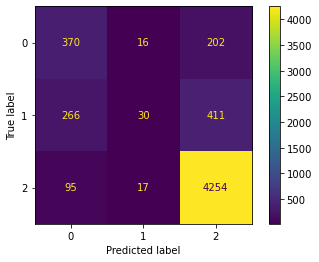

In [28]:
cm = np.array([[ 370, 16, 202],[266, 30, 411],[95, 17, 4254]])
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='viridis')

CountVectorizer approach was used regarding benchmark model.
<br> Benchmark Model (Multinomial Naive Bayes) obtained 80,6% accuracy.
<br> 2 approaches were used regarding student model.
<br> First embedding matrix was built using GloVe approach.
<br> Second one was built using Word2Vec approach.
<br> Final LSTM model which uses GloVe approach has following parameters: 1 hidden layer, 0,4 dropout rate, learning rate equals 0.01 and 5 epochs.
<br> Final LSTM model which uses Word2Vec approach has following parameters: 2 hidden layer, 0,4 dropout rate, learning rate equals 0.001 and 13 epochs.
<br> Final model predicts reviews based on predictictions from GloVe LSTM model and Word2Vec LSTM model.
<br> Accuracy of the student model equals 82,2%.